In [80]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd

In [81]:
# Indicators which are expected to indicate urbanization if their values are high
URBANIZATION_INDICATORS = [
    'Air transport, freight (million ton-km)',
    'Air transport, passengers carried',
    'Annual freshwater withdrawals, industry (% of total freshwater withdrawal)',
    'CO2 emissions (metric tons per capita)',
    'Commercial bank branches (per 100,000 adults)',
    'Employment in industry (% of total employment) (modeled ILO estimate)',
    'Employment in services (% of total employment) (modeled ILO estimate)',
    'Industry (including construction), value added per worker (constant 2010 US$)',
    'Manufacturing, value added (% of GDP)',
    'Medium and high-tech industry (% manufacturing value added)',
    'Railways, goods transported (million ton-km)',
    'Railways, passengers carried (million passenger-km)',
    'Urban population (% of total)',
    
    # Other indicators that could be used (internet access tends to be better in densely populated areas, more universities in
    # cities)
    'Individuals using the Internet (% of population)',
    "Educational attainment, competed at least Bachelor's or equivalent, population 25+, total (%) (cumulative)",
    "Educational attainment, competed at least Master's or equivalent, population 25+, total (%) (cumulative)",
]

# Indiccators which are expected to indicate urbanization if their values are low
ANTI_URBANIZATION_INDICATORS = [
    'Agriculture, forestry, and fishing, value added per worker (constant 2010 US$)',
    'Annual freshwater withdrawals, agriculture (% of total freshwater withdrawal)',
    'Employment in agriculture (% of total employment) (modeled ILO estimate)',
    'Forest area (% of land area)',
]

In [82]:
df = pd.read_csv('tmp/developing_countries.csv')
df.head()


,Country,Country code,Year,Happiness rank,Happiness score,GDP per capita,Social support,Life expectancy,Freedom,Perceptions of corruption,...,Employment in industry (% of total employment) (modeled ILO estimate),Employment in services (% of total employment) (modeled ILO estimate),Forest area (% of land area),Individuals using the Internet (% of population),"Industry (including construction), value added per worker (constant 2010 US$)","Manufacturing, value added (% of GDP)",Medium and high-tech industry (% manufacturing value added),"Railways, goods transported (million ton-km)","Railways, passengers carried (million passenger-km)",Urban population (% of total)
0,Afghanistan,AFG,2015,153,3.575,0.319820,0.302850,0.303350,0.23414,0.097190,...,17.646999,43.674999,2.067825,8.260000,2079.555916,11.420006,9.507434,NaN,NaN,24.803
1,Afghanistan,AFG,2016,154,3.360,0.382270,0.110370,0.173440,0.16430,0.071120,...,17.424999,43.756001,2.067825,10.595726,1999.566153,11.370465,NaN,NaN,NaN,25.020
2,Afghanistan,AFG,2017,141,3.794,0.401477,0.581543,0.180747,0.10618,0.061158,...,17.457001,43.768002,NaN,11.447688,1923.393447,11.102526,NaN,NaN,NaN,25.250
3,Afghanistan,AFG,2018,145,3.632,0.332000,0.537000,0.255000,0.08500,0.036000,...,17.596001,43.816002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Albania,ALB,2015,95,4.959,0.878670,0.804340,0.813250,0.35733,0.064130,...,18.617001,40.020000,28.156934,63.252933,13648.254549,5.671519,6.690696,NaN,NaN,57.434


In [83]:
threshold = 0.6
df_thresh = df.dropna(axis=1, thresh=int(df.shape[0] * threshold))
df_impute = df_thresh.fillna(df_thresh.mean())
df_impute.describe()

/tmp/ipykernel_16274/3317798125.py:3: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_impute = df_thresh.fillna(df_thresh.mean())


,Year,Happiness rank,Happiness score,GDP per capita,Social support,Life expectancy,Freedom,Perceptions of corruption,Generosity,Dystopia residual,"Agriculture, forestry, and fishing, value added per worker (constant 2010 US$)","Air transport, passengers carried","Commercial bank branches (per 100,000 adults)",Employment in agriculture (% of total employment) (modeled ILO estimate),Employment in industry (% of total employment) (modeled ILO estimate),Employment in services (% of total employment) (modeled ILO estimate),Individuals using the Internet (% of population),"Industry (including construction), value added per worker (constant 2010 US$)","Manufacturing, value added (% of GDP)",Urban population (% of total)
count,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,4.570000e+02,4.570000e+02,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000
mean,2016.494530,92.221007,5.022313,0.795687,0.974366,0.512896,0.389140,0.104963,0.214298,2.030955,2.076123e+04,1.814317e+07,13.890841,31.216241,19.793201,48.990571,42.805461,23036.702831,12.666669,55.169177
std,1.118266,39.978960,0.968432,0.365876,0.323990,0.213048,0.150710,0.082750,0.120375,0.585681,1.515434e+05,4.409611e+07,9.118862,21.638516,8.503950,15.875213,21.451886,25886.912377,4.922361,18.276113
min,2015.000000,12.000000,2.693000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001990,0.291000,1.836964e+02,8.990000e+02,0.454000,0.058000,2.086000,5.957000,1.880000,639.511832,1.768629,12.078000
25%,2015.000000,59.000000,4.308000,0.493000,0.777110,0.345780,0.288516,0.054000,0.134000,1.683024,1.852477e+03,1.285642e+06,8.577994,13.104000,13.222000,38.425999,25.664768,9499.450371,10.818186,45.862000
50%,2016.000000,94.000000,5.082000,0.860860,1.003187,0.579000,0.406720,0.085460,0.200000,1.980000,6.568982e+03,1.328510e+07,13.890841,28.452999,19.929001,50.950001,42.805461,23036.702831,12.666669,55.169177
75%,2017.000000,127.000000,5.822000,1.061660,1.226680,0.678060,0.499000,0.128000,0.264750,2.393740,2.076123e+04,1.814317e+07,14.056147,44.521999,25.368999,61.146000,57.272244,23036.702831,13.731697,65.850000
max,2018.000000,158.000000,7.226000,1.870766,1.584000,0.965380,0.724000,0.551910,0.838075,3.837720,2.893900e+06,5.512345e+08,70.561644,91.957001,54.555000,77.537003,97.999989,180220.430997,38.334660,100.000000


## Using sgd data to predict wh data

In [84]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df_impute, test_size=0.2)

In [85]:
def split_X_Y(df: pd.DataFrame):
    cols = set(df.columns)
    sgd_cols = set(URBANIZATION_INDICATORS + ANTI_URBANIZATION_INDICATORS)
    mutual = cols.intersection(sgd_cols)
    sgd = df[list(mutual)]

    wh_cols = list(cols - sgd_cols)
    wh = df[wh_cols].drop(['Country', 'Happiness rank', 'Happiness score', 'Country code', 'Year'], axis=1)

    return sgd, wh

In [86]:
from sklearn import preprocessing
def norm_transform_gen(data: np.ndarray):
    scaler = preprocessing.MinMaxScaler().fit(data)
    # scaler = preprocessing.StandardScaler().fit(data)
    return scaler

In [87]:
X, Y = split_X_Y(train)

In [88]:
X

,Employment in services (% of total employment) (modeled ILO estimate),Individuals using the Internet (% of population),"Air transport, passengers carried",Employment in industry (% of total employment) (modeled ILO estimate),"Manufacturing, value added (% of GDP)","Industry (including construction), value added per worker (constant 2010 US$)","Commercial bank branches (per 100,000 adults)",Urban population (% of total),"Agriculture, forestry, and fishing, value added per worker (constant 2010 US$)",Employment in agriculture (% of total employment) (modeled ILO estimate)
392,25.847000,13.000000,1.179664e+06,6.646000,7.813718,7620.924223,13.890841,32.333000,625.446852,67.507004
420,21.648001,23.706531,5.493700e+04,7.282000,8.593108,4665.656876,2.578919,23.196000,553.076465,71.070000
87,17.718000,3.800000,1.814317e+07,8.708000,6.802004,1458.078618,0.664421,40.277000,456.125272,73.573997
169,30.101999,26.000000,9.892786e+07,24.339001,15.583855,5811.116729,13.544573,32.777000,1512.488951,45.558998
44,38.792999,11.994048,8.990000e+02,19.094000,11.873931,2479.940308,3.622142,46.229000,1042.101030,42.112999
...,...,...,...,...,...,...,...,...,...,...
269,50.648998,22.265770,5.378530e+05,18.990999,7.324357,18852.347093,70.366401,68.297000,4538.154879,30.360001
48,32.694000,41.772645,2.241010e+05,9.736000,7.432100,25416.040219,15.269140,39.428000,1458.061725,57.570000
432,71.625000,42.805461,1.814317e+07,19.724001,12.666669,23036.702831,13.890841,55.169177,20761.228907,8.651000
382,68.174004,45.400000,2.800900e+05,24.608999,13.275862,30381.911253,11.237739,66.040000,34083.551970,7.217000


In [89]:
Y

,Freedom,GDP per capita,Dystopia residual,Life expectancy,Social support,Generosity,Perceptions of corruption
392,0.317600,0.471550,1.377690,0.357000,0.776230,0.314720,0.05099
420,0.443186,0.381431,1.526363,0.217633,1.129828,0.325766,0.05707
87,0.488790,0.078500,2.722300,0.066990,0.000000,0.238350,0.08289
169,0.397860,0.644990,2.275130,0.515290,0.381740,0.264750,0.08492
44,0.397470,0.394990,2.108120,0.210280,0.104190,0.201800,0.06681
...,...,...,...,...,...,...,...
269,0.359720,0.988530,1.535860,0.554690,1.089830,0.345390,0.03285
48,0.460740,0.852700,1.829160,0.497590,0.908360,0.485460,0.16160
432,0.625000,1.093000,2.146000,0.771000,1.459000,0.130000,0.15500
382,0.522340,1.096860,3.068520,0.509330,0.778660,0.166650,0.12692


In [142]:
X_scaler = norm_transform_gen(X.to_numpy())
Y_scaler = norm_transform_gen(Y.to_numpy())
X_scaled = X_scaler.transform(X.to_numpy())
Y_scaled = Y_scaler.transform(Y.to_numpy())

In [143]:
class FeaturePredictNN(nn.Module):
    def __init__(self, in_features, out_features, hidden_size=20) -> None:
        super().__init__() 
        self.linear1 = nn.Linear(in_features=in_features, out_features=hidden_size)
        self.sig1 = nn.Sigmoid()
        self.linear2 = nn.Linear(in_features=hidden_size, out_features=out_features)
    
    def forward(self, x):
        hidden = self.sig1(self.linear1(x))
        out = self.linear2(hidden)
        return out
        

In [144]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X = torch.Tensor(X_scaled).to(device)
Y = torch.Tensor(Y_scaled).to(device)

In [145]:
model = FeaturePredictNN(10, 7).to(device)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
epoches = 200

In [146]:
X_test, Y_test = split_X_Y(test)
X_test = X_scaler.transform(X_test.to_numpy())
Y_test = Y_scaler.transform(Y_test.to_numpy())
X_test = torch.Tensor(X_test).to(device)
Y_test = torch.Tensor(Y_test).to(device)
mse_loss = nn.MSELoss()

In [147]:
losses = []
test_losses = []
for epoch in range(1, epoches+1):
    inputs = X
    targets = Y

    optimizer.zero_grad()
    
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()

    test_outputs = model(X_test)
    test_loss = mse_loss(test_outputs, Y_test)
    test_losses.append(test_loss.item())

    losses.append(loss.item())

    if epoch % (epoches//10) == 0:
        print(f"loss: {loss.item()}") 

loss: 0.03883922100067139
loss: 0.03598988428711891
loss: 0.0355498269200325
loss: 0.035026051104068756
loss: 0.03483537212014198
loss: 0.0346950925886631
loss: 0.034557487815618515
loss: 0.03442143276333809
loss: 0.03428690880537033
loss: 0.03415374457836151


In [149]:
import matplotlib.pyplot as plt

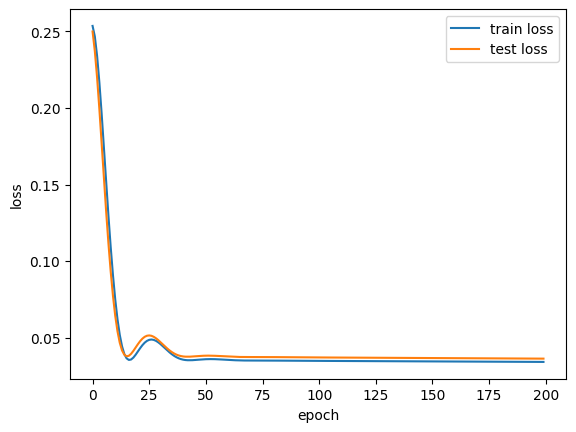

In [148]:
plt.plot(losses)
plt.plot(test_losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train loss', 'test loss'])

In [19]:
torch.save(model.state_dict(), 'weights/fenn.pt')

In [150]:
X_max = X_scaler.data_max_.copy()
X_min = X_scaler.data_min_.copy()

In [151]:
X_end = X_max.copy()
tmp = X_min.copy()
tmp[1:] = 0
print(tmp)

X_start = X_end - tmp

print(X_end)
print(X_start)

X_original = np.linspace(X_start, X_end, 50)
X_scaled = X_scaler.transform(X_original)

[5.95699978 0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
[7.75370026e+01 9.79999893e+01 5.51234509e+08 5.45050011e+01
 3.83346604e+01 1.80220431e+05 7.03664006e+01 1.00000000e+02
 3.40835520e+04 9.19570007e+01]
[7.15800028e+01 9.79999893e+01 5.51234509e+08 5.45050011e+01
 3.83346604e+01 1.80220431e+05 7.03664006e+01 1.00000000e+02
 3.40835520e+04 9.19570007e+01]


In [152]:
y_out = model(torch.Tensor(X_scaled).to(device))

In [153]:
print(y_out.shape)

torch.Size([50, 7])


In [154]:
X_plot = X_original
y_plot = Y_scaler.transform(y_out.cpu().detach().numpy())

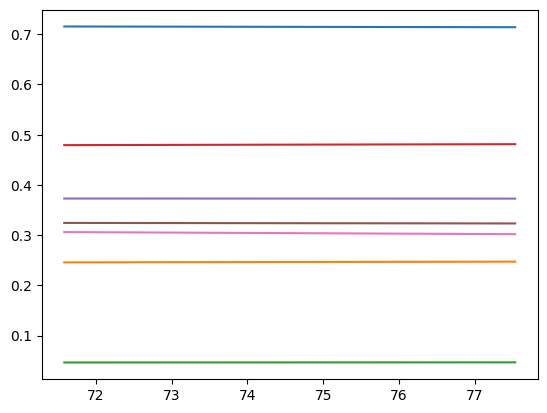

In [155]:
plt.plot(X_plot[:,0], y_plot[:, 0])
plt.plot(X_plot[:,0], y_plot[:, 1])
plt.plot(X_plot[:,0], y_plot[:, 2])
plt.plot(X_plot[:,0], y_plot[:, 3])
plt.plot(X_plot[:,0], y_plot[:, 4])
plt.plot(X_plot[:,0], y_plot[:, 5])
plt.plot(X_plot[:,0], y_plot[:, 6])

In [162]:
X, Y = split_X_Y(train)
X_columns = X.columns
y_columns = Y.columns



In [202]:
from math import ceil
def one2many(X, Y, X_scaler=X_scaler, Y_scaler=Y_scaler):
    # for each factors in sgd data, there will be two values in side in array form
    # eg:
    # res = [[X_plot, Y_plot], ..., [X_plot, Y_plot]]
    res = []

    X_max = X_scaler.data_max_.copy()
    X_min = X_scaler.data_min_.copy()

    for i in range(X.shape[1]):
        X_end = X_max.copy()
        tmp = X_min.copy()
        tmp[i+1:] = 0

        X_start = X_end - tmp

        X_original = np.linspace(X_start, X_end, 50)
        X_scaled = X_scaler.transform(X_original)

        y_out = model(torch.Tensor(X_scaled).to(device))

        X_plot = X_scaled
        y_plot = Y_scaler.transform(y_out.cpu().detach().numpy())

        res.append([X_plot[:, i], y_plot])
    
    return res

# data is in form one2many returns
def plotDiff(data, x_labels, y_labels, n_cols=3, figure_size=(3, 3)):
    n_rows = ceil(len(y_labels) / n_cols)
    figure, axis = plt.subplots(n_rows, n_cols)

    figure.set_size_inches(figure_size)
    figure.tight_layout(pad=5.0)

    for i in range(len(y_labels)):
        row = i // n_cols
        col = i % n_cols

        for j in range(len(x_labels)):
            X2plot = data[j][0]
            Y2plot = data[j][1]
            axis[row, col].plot(X2plot, Y2plot[:, i])

            axis[row, col].set_xlabel('value of sgd factors')
            axis[row, col].set_ylabel(y_labels[i])

    
    for i in range(len(y_labels), n_rows*n_cols):
        row = i // n_cols
        col = i % n_cols
        axis[row, col].axis('off')
    
    figure.legend(x_labels, loc='lower right')
    return figure

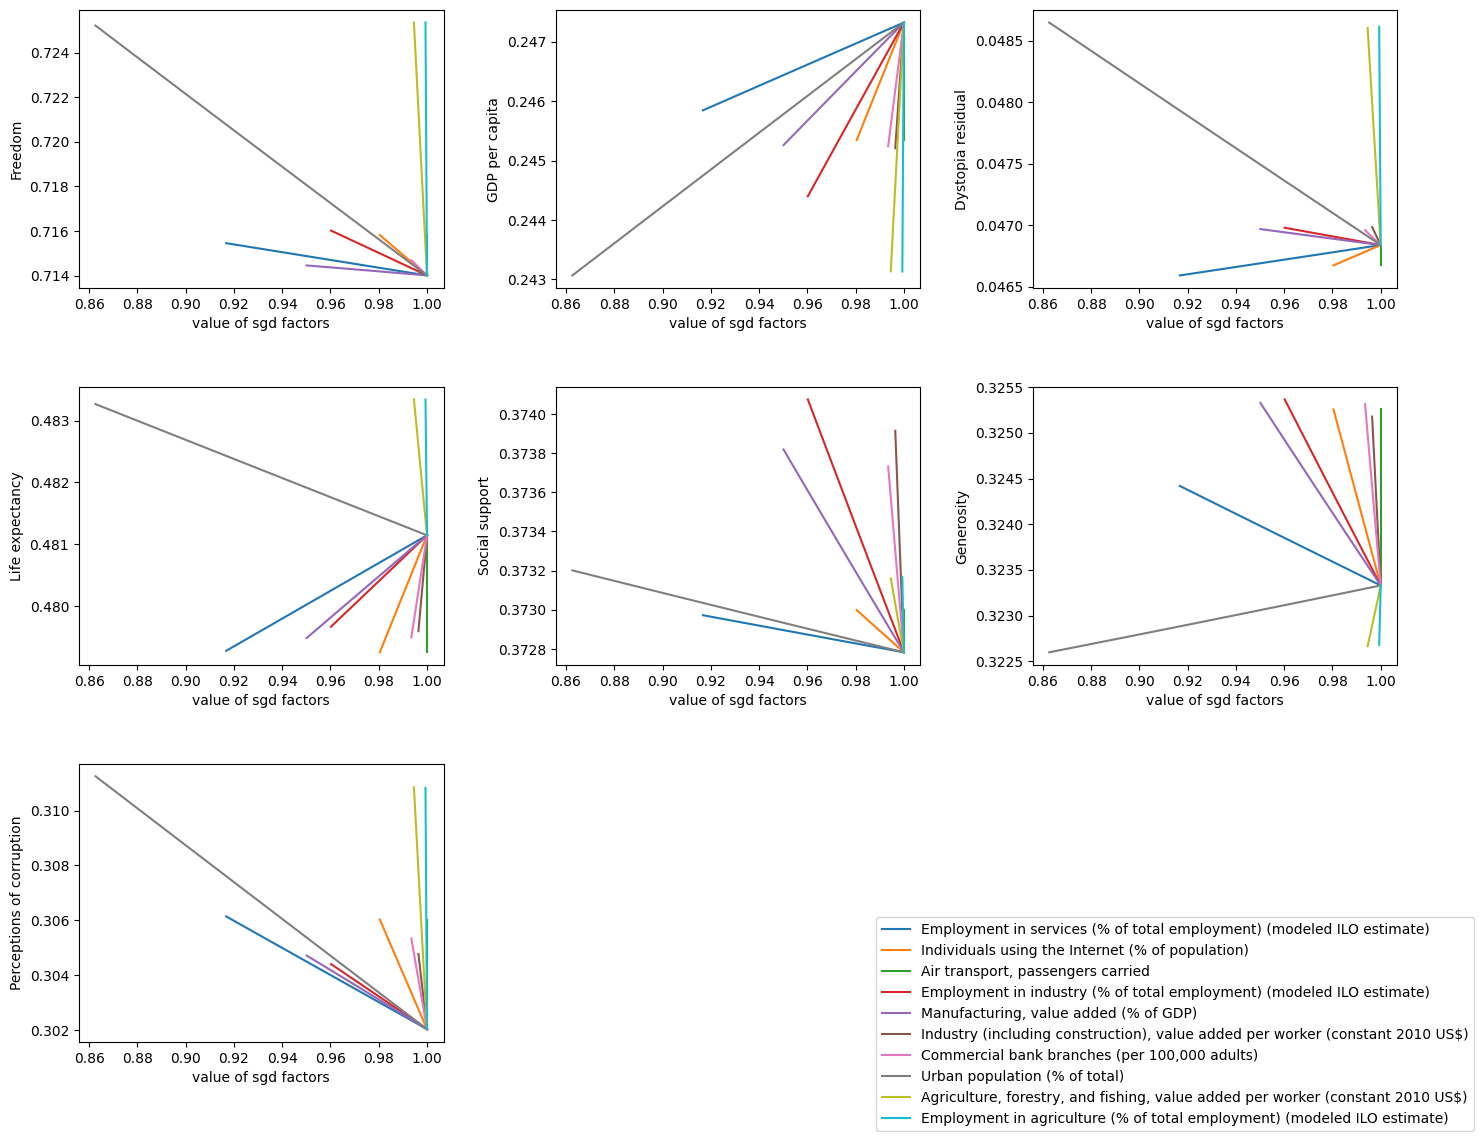

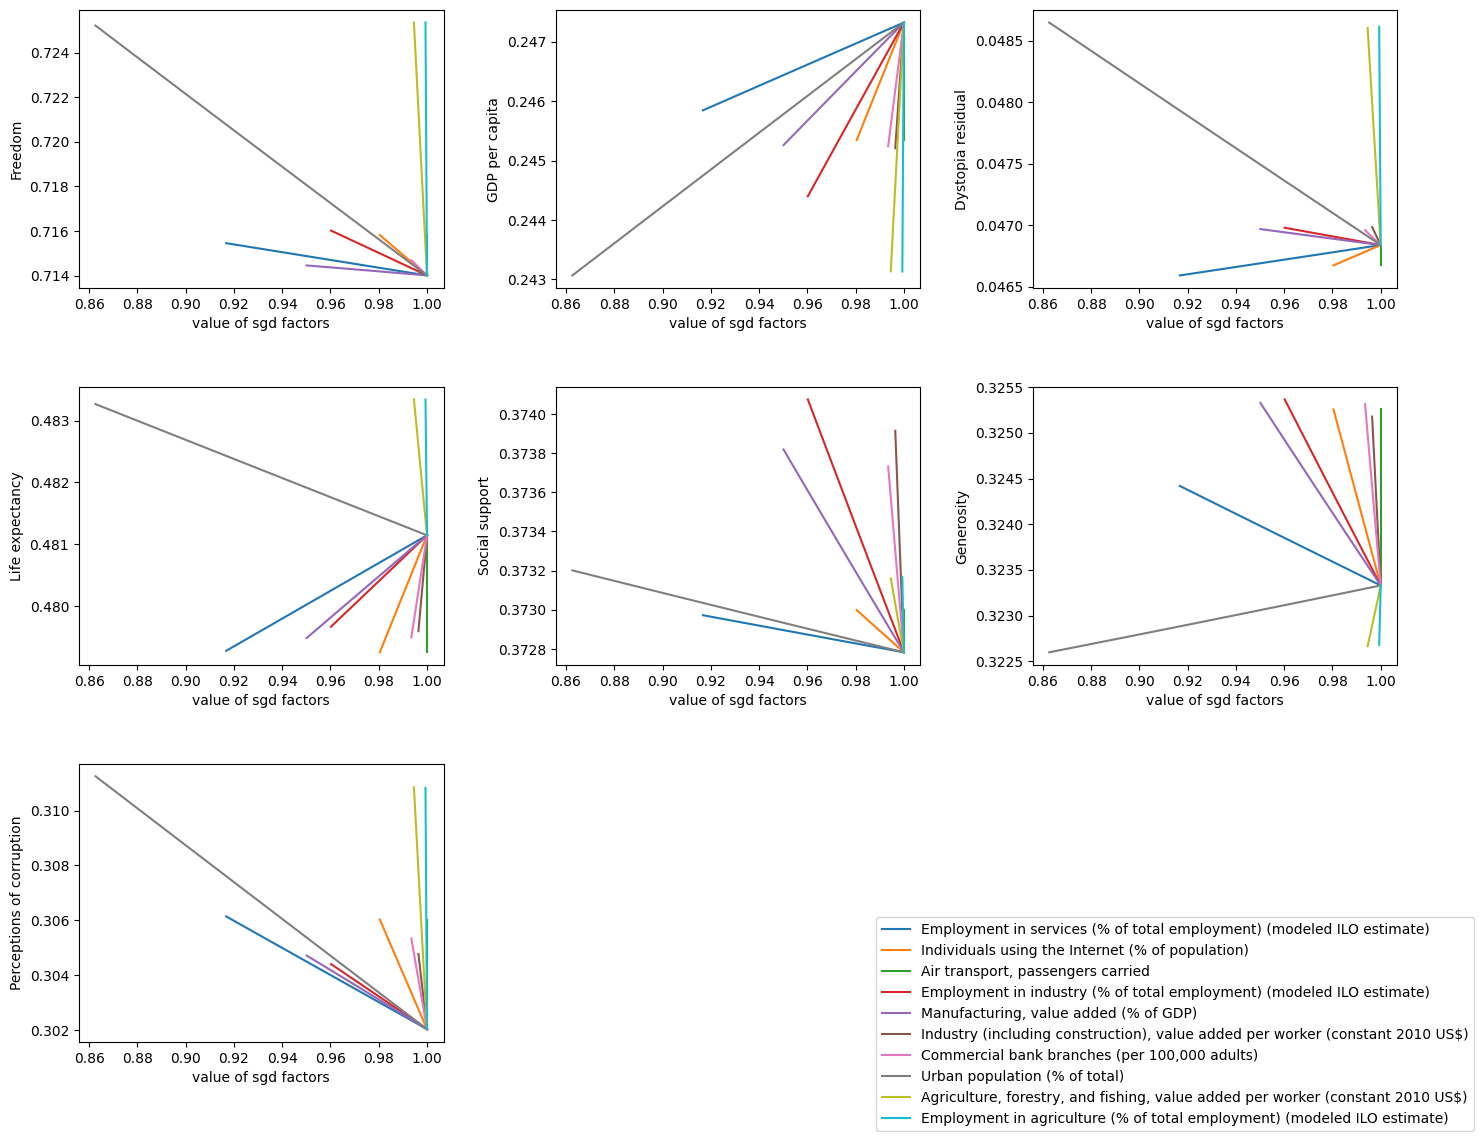

In [203]:
res = one2many(X, Y)
plotDiff(res, X_columns, y_columns, figure_size=(15, 12))

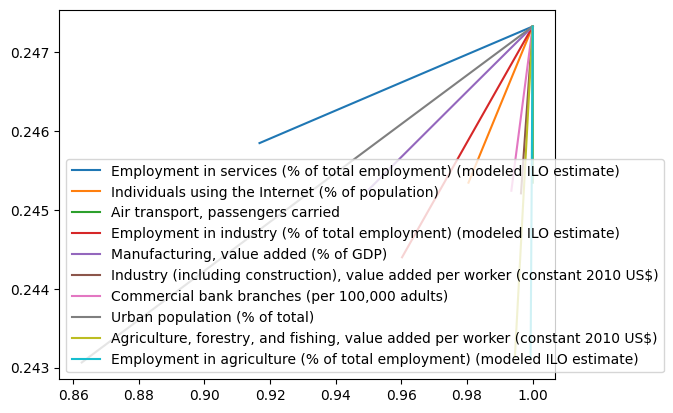

In [177]:
for i in range(len(X_columns)):
    X2plot = res[i][0]
    Y2plot = res[i][1]

    plt.plot(X2plot, Y2plot[:, 1])

plt.legend(X_columns)

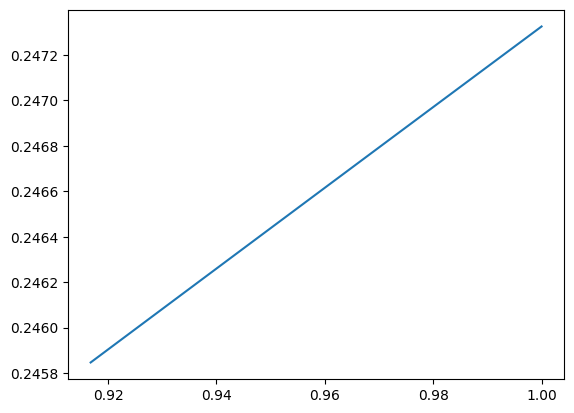

In [175]:
plt.plot(res[0][0], res[0][1][:, 1])

## Happiness Score model

In [20]:
wh_df = df.iloc[:, :12]
print(wh_df.isna().sum().sum())
wh_df_numeric= wh_df.drop(['Country', 'Country code', 'Year', 'Happiness rank'], axis=1)
wh_df_numeric.head()

0


,Happiness score,GDP per capita,Social support,Life expectancy,Freedom,Perceptions of corruption,Generosity,Dystopia residual
0,3.575,0.319820,0.302850,0.303350,0.23414,0.097190,0.365100,1.952100
1,3.360,0.382270,0.110370,0.173440,0.16430,0.071120,0.312680,2.145580
2,3.794,0.401477,0.581543,0.180747,0.10618,0.061158,0.311871,2.150801
3,3.632,0.332000,0.537000,0.255000,0.08500,0.036000,0.191000,2.196000
4,4.959,0.878670,0.804340,0.813250,0.35733,0.064130,0.142720,1.898940


In [21]:
train, test = train_test_split(wh_df_numeric, test_size=0.1)
print(train.shape)
print(test.shape)

(411, 8)
(46, 8)


In [22]:
from sklearn.preprocessing import PolynomialFeatures
def transform(data):
    X_origin = data.drop('Happiness score', axis=1).to_numpy()
    poly_transformer = PolynomialFeatures(degree=2, include_bias=False)
    X_poly = poly_transformer.fit_transform(X_origin)
    return X_poly, data['Happiness score'].to_numpy().reshape((-1, 1))

In [23]:
X_train, y_train = transform(train)
print(X_train.shape)
print(y_train.shape)

(411, 35)
(411, 1)


In [24]:
from sklearn.linear_model import LinearRegression

poly_model = LinearRegression()
poly_model.fit(X_train, y_train)

LinearRegression()

In [25]:
X_test, y_test = transform(test)
y_preds = poly_model.predict(X_test)

In [26]:
from sklearn.metrics import mean_squared_error

mae = mean_squared_error(y_test, y_preds)
print(mae)

5.587798792901008e-08


## Urbanization indicators modeling

In [27]:
import pycountry
def get3countryCode(names):
    # Store the country codes that are found in a dictionary to speed up the function
    code_map = dict()
    
    res = []
    for name in names:
        try:
            try:
                code = code_map[name]
            except KeyError:
                code = pycountry.countries.search_fuzzy(name)[0].alpha_3
                code_map[name] = code
                
            res.append(code)
        except LookupError:
            res.append(None)
    
    return pd.Series(res)

In [28]:
developed_countries = pd.read_csv(f'./dataset/developed_countries.csv')
developed_countries['Country code'] = get3countryCode(developed_countries['Country'])

In [29]:
sgd = pd.read_csv('./dataset/world_happiness/sustainable_develop_goals/sdg-csv-zip-7-mb-/SDGData.csv')
sgd_urban = sgd[sgd['Indicator Name'].isin(
    URBANIZATION_INDICATORS + ANTI_URBANIZATION_INDICATORS
)].iloc[:, :33].sort_values(by=['Country Name', 'Indicator Name']).reset_index(drop=True)
print(sgd_urban.shape)
sgd_urban

(5260, 33)


,Country Name,Country Code,Indicator Name,Indicator Code,1990,1991,1992,1993,1994,1995,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,Afghanistan,AFG,"Agriculture, forestry, and fishing, value adde...",NV.AGR.EMPL.KD,NaN,NaN,NaN,NaN,NaN,NaN,...,919.727932,9.150535e+02,8.850408e+02,1.137182e+03,1.084252e+03,1.028653e+03,9.213596e+02,9.308000e+02,9.285927e+02,NaN
1,Afghanistan,AFG,"Air transport, freight (million ton-km)",IS.AIR.GOOD.MT.K1,9.400000,8.400000,8.400000,6.700000,12.300000,12.900000,...,NaN,1.080195e+02,1.094211e+02,1.166607e+02,8.462122e+01,3.428347e+01,3.310204e+01,2.901088e+01,2.514421e+01,NaN
2,Afghanistan,AFG,"Air transport, passengers carried",IS.AIR.PSGR,241400.000000,212300.000000,212300.000000,197000.000000,238400.000000,250400.000000,...,NaN,1.999127e+06,2.279341e+06,1.737962e+06,2.044188e+06,2.209428e+06,1.929907e+06,1.917924e+06,1.858558e+06,NaN
3,Afghanistan,AFG,"Annual freshwater withdrawals, agriculture (% ...",ER.H2O.FWAG.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Afghanistan,AFG,"Annual freshwater withdrawals, industry (% of ...",ER.H2O.FWIN.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5255,Zimbabwe,ZWE,"Manufacturing, value added (% of GDP)",NV.IND.MANF.ZS,20.484785,24.096142,26.898699,21.021162,19.054827,19.264222,...,11.030513,9.208113e+00,9.172401e+00,1.404340e+01,1.291906e+01,1.259076e+01,1.188860e+01,1.159602e+01,1.101701e+01,NaN
5256,Zimbabwe,ZWE,Medium and high-tech industry (% manufacturing...,NV.MNF.TECH.ZS.UN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5257,Zimbabwe,ZWE,"Railways, goods transported (million ton-km)",IS.RRS.GOOD.MT.K6,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5258,Zimbabwe,ZWE,"Railways, passengers carried (million passenge...",IS.RRS.PASG.KM,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
sgd_urban.isna().sum(axis=1)

0       13
1       10
2       10
3       28
4       28
        ..
5255     1
5256    29
5257    28
5258    29
5259     1
Length: 5260, dtype: int64

In [31]:
sgd_urban[sgd_urban['Country Name'] == 'Zimbabwe'].isna().sum().sum()

233

In [32]:
shape = sgd_urban[sgd_urban['Country Name'] == 'Zimbabwe'].shape
cell_total = shape[0] * shape[1]
print(cell_total)

660


In [33]:
### time series data preparing
row = sgd_urban.iloc[4, :]
def impute_row(row):
    row_numeric = row.iloc[4:].to_numpy()

    row_numeric.shape

    i = 0
    while i < row_numeric.shape[0] and np.isnan(row_numeric[i]):
        row_numeric[i] = 0
        i += 1

    j = i + 1

    while i < row_numeric.shape[0]:
        while i < row_numeric.shape[0] and not np.isnan(row_numeric[i]):
            i += 1

        if i == row_numeric.shape[0]:
            break
        
        j = i
        i -= 1 

        while j < row_numeric.shape[0] and np.isnan(row_numeric[j]):
            j += 1
        
        # means all the values behind index i is null
        if j == row_numeric.shape[0]:
            for index in range(i+1, j):
                row_numeric[index] = row_numeric[i]
        else:
            for index in range(i+1, j):
                row_numeric[index] = row_numeric[i] + (row_numeric[j] - row_numeric[i]) * (index-i) / (j-i)
    
    row.iloc[4:] = row_numeric
        
    return row

impute_row(row)

/tmp/ipykernel_143382/355607106.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row.iloc[4:] = row_numeric


Country Name                                            Afghanistan
Country Code                                                    AFG
Indicator Name    Annual freshwater withdrawals, industry (% of ...
Indicator Code                                       ER.H2O.FWIN.ZS
1990                                                              0
1991                                                              0
1992                                                              0
1993                                                              0
1994                                                              0
1995                                                              0
1996                                                              0
1997                                                              0
1998                                                              0
1999                                                              0
2000                                            

In [34]:
sgd_imputed = sgd_urban.apply(impute_row, axis=1)

In [35]:
sgd_imputed

,Country Name,Country Code,Indicator Name,Indicator Code,1990,1991,1992,1993,1994,1995,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,Afghanistan,AFG,"Agriculture, forestry, and fishing, value adde...",NV.AGR.EMPL.KD,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,9.197279e+02,9.150535e+02,8.850408e+02,1.137182e+03,1.084252e+03,1.028653e+03,9.213596e+02,9.308000e+02,9.285927e+02,9.285927e+02
1,Afghanistan,AFG,"Air transport, freight (million ton-km)",IS.AIR.GOOD.MT.K1,9.400000,8.400000,8.400000,6.700000,12.300000,12.900000,...,9.799884e+01,1.080195e+02,1.094211e+02,1.166607e+02,8.462122e+01,3.428347e+01,3.310204e+01,2.901088e+01,2.514421e+01,2.514421e+01
2,Afghanistan,AFG,"Air transport, passengers carried",IS.AIR.PSGR,241400.000000,212300.000000,212300.000000,197000.000000,238400.000000,250400.000000,...,1.814185e+06,1.999127e+06,2.279341e+06,1.737962e+06,2.044188e+06,2.209428e+06,1.929907e+06,1.917924e+06,1.858558e+06,1.858558e+06
3,Afghanistan,AFG,"Annual freshwater withdrawals, agriculture (% ...",ER.H2O.FWAG.ZS,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,9.862000e+01,9.862000e+01,9.862000e+01,9.862000e+01,9.862000e+01,9.862000e+01,9.862000e+01,9.862000e+01,9.862000e+01,9.862000e+01
4,Afghanistan,AFG,"Annual freshwater withdrawals, industry (% of ...",ER.H2O.FWIN.ZS,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,6.336000e-01,6.336000e-01,6.336000e-01,6.336000e-01,6.336000e-01,6.336000e-01,6.336000e-01,6.336000e-01,6.336000e-01,6.336000e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5255,Zimbabwe,ZWE,"Manufacturing, value added (% of GDP)",NV.IND.MANF.ZS,20.484785,24.096142,26.898699,21.021162,19.054827,19.264222,...,1.103051e+01,9.208113e+00,9.172401e+00,1.404340e+01,1.291906e+01,1.259076e+01,1.188860e+01,1.159602e+01,1.101701e+01,1.101701e+01
5256,Zimbabwe,ZWE,Medium and high-tech industry (% manufacturing...,NV.MNF.TECH.ZS.UN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
5257,Zimbabwe,ZWE,"Railways, goods transported (million ton-km)",IS.RRS.GOOD.MT.K6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.580000e+03,1.580000e+03,1.580000e+03,1.580000e+03,1.580000e+03,1.580000e+03,1.580000e+03,1.580000e+03,1.580000e+03,1.580000e+03
5258,Zimbabwe,ZWE,"Railways, passengers carried (million passenge...",IS.RRS.PASG.KM,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


In [36]:
indicators_ranges = {}

for indicator in URBANIZATION_INDICATORS + ANTI_URBANIZATION_INDICATORS:
    indicator_max = sgd_imputed[sgd_imputed['Indicator Name'] == indicator].iloc[:, 4:].max().max()
    indicator_min = sgd_imputed[sgd_imputed['Indicator Name'] == indicator].iloc[:, 4:].min().min()
    indicators_ranges[indicator] = {
        "max": indicator_max,
        "min": indicator_min
    }

indicators_ranges

indicator = 'Air transport, freight (million ton-km)'

In [37]:
row = sgd_imputed.iloc[0, :]
def rescale_row(row):
    row_numeric = row.iloc[4:].to_numpy()
    indicator = row['Indicator Name']

    row_numeric -= indicators_ranges[indicator]['min']
    row_numeric /= indicators_ranges[indicator]['max']
    row_numeric

    row.iloc[4:] = row_numeric

    return row

In [38]:
sgd_rescaled = sgd_imputed.apply(rescale_row, axis=1)

In [39]:
sgd_rescaled

,Country Name,Country Code,Indicator Name,Indicator Code,1990,1991,1992,1993,1994,1995,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,Afghanistan,AFG,"Agriculture, forestry, and fishing, value adde...",NV.AGR.EMPL.KD,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000318,0.000316,0.000306,0.000393,0.000375,0.000355,0.000318,0.000322,0.000321,0.000321
1,Afghanistan,AFG,"Air transport, freight (million ton-km)",IS.AIR.GOOD.MT.K1,0.000044,0.000039,0.000039,0.000031,0.000058,0.000060,...,0.000459,0.000506,0.000512,0.000546,0.000396,0.000161,0.000155,0.000136,0.000118,0.000118
2,Afghanistan,AFG,"Air transport, passengers carried",IS.AIR.PSGR,0.000061,0.000053,0.000053,0.000050,0.000060,0.000063,...,0.000456,0.000502,0.000573,0.000437,0.000514,0.000555,0.000485,0.000482,0.000467,0.000467
3,Afghanistan,AFG,"Annual freshwater withdrawals, agriculture (% ...",ER.H2O.FWAG.ZS,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.989168,0.989168,0.989168,0.989168,0.989168,0.989168,0.989168,0.989168,0.989168,0.989168
4,Afghanistan,AFG,"Annual freshwater withdrawals, industry (% of ...",ER.H2O.FWIN.ZS,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.006585,0.006585,0.006585,0.006585,0.006585,0.006585,0.006585,0.006585,0.006585,0.006585
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5255,Zimbabwe,ZWE,"Manufacturing, value added (% of GDP)",NV.IND.MANF.ZS,0.361598,0.425346,0.474817,0.371066,0.336356,0.340053,...,0.194711,0.162542,0.161912,0.247895,0.228048,0.222253,0.209858,0.204693,0.194473,0.194473
5256,Zimbabwe,ZWE,Medium and high-tech industry (% manufacturing...,NV.MNF.TECH.ZS.UN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5257,Zimbabwe,ZWE,"Railways, goods transported (million ton-km)",IS.RRS.GOOD.MT.K6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000585,0.000585,0.000585,0.000585,0.000585,0.000585,0.000585,0.000585,0.000585,0.000585
5258,Zimbabwe,ZWE,"Railways, passengers carried (million passenge...",IS.RRS.PASG.KM,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [40]:
## Model - encoder and decoder manner
import torch.nn as nn
class IndicatorPredictNN(nn.Module):
    def __init__(self, indicators_dim, hidden_size, rnn_hidden, batch_size, rnn_layers=2) -> None:
        super().__init__()

        self.batch_size = batch_size
        self.rnn_layers = rnn_layers
        self.rnn_hidden = rnn_hidden

        self.linear = nn.Linear(indicators_dim, hidden_size)
        self.rnn = nn.LSTM(hidden_size, rnn_hidden, rnn_layers, batch_first=True)

        self.linear2 = nn.Linear(rnn_hidden, indicators_dim)
    
    def init_hidden(indicators_dim, hidden_dim):
        pass
    
    def forward(self, x):
        out = self.linear(x) 
        h0, c0 = self.init_hidden(self.batch_size, self.rnn_layers, self.rnn_hidden)

        out, _ = self.rnn(out, (h0, c0))
        out = self.linear2(out[:, -1, :])

        return out


    def init_hidden(self, batch_size, rnn_layers, rnn_hidden, bidirection=False, device=torch.device("cuda")):
        h0 = torch.randn((1+bidirection)*rnn_layers, batch_size, rnn_hidden, device=device)
        c0 = torch.randn((1+bidirection)*rnn_layers, batch_size, rnn_hidden, device=device)
        return h0, c0
        
        

In [41]:
indicators_dim = sgd_imputed['Indicator Name'].unique().shape[0]
indicators_dim

20

In [42]:
afg = sgd_imputed.iloc[:20, :]
col = afg.iloc[0:, 4:6].to_numpy(dtype=np.float32)
col
X = torch.Tensor(col).T
X.shape

torch.Size([2, 20])

In [43]:
device = torch.device('cuda')

In [44]:
data = sgd_rescaled.iloc[:, 4:].to_numpy()
# data = data.T
data = data.reshape((263, 20, 29))
data = data.transpose((0, 2, 1))

In [45]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.2)
print(train.shape)
print(test.shape)

(210, 29, 20)
(53, 29, 20)


In [46]:
model = IndicatorPredictNN(indicators_dim, 20, 40, 10)
model.to(device)

n_epochs = 1000
lr = 0.01
device = torch.device('cuda')

# criterion = nn.CrossEntropyLoss()
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [47]:
losses = []
test_losses = []
for epoch in range(1, n_epochs):
    optimizer.zero_grad()
    loss_total = 0

    for i in range(21):
        X = torch.Tensor(train[i*10:(i+1)*10, :28, :]).to(device)
        y = torch.Tensor(train[i*10:(i+1)*10, 28, :]).to(device)

        # print(X.shape)

        out = model(X)
        loss = criterion(out, y)

        loss.backward()

        loss_total += loss.item()
    
    optimizer.step()

    loss_total_test = 0
    for i in range(test.shape[0] // 10):
        start = i*10
        end = (i+1)*10
        if end > test.shape[0]:
            start = end - 10
        
        X_test = torch.Tensor(test[start:end, :28, :]).to(device)
        y_test = torch.Tensor(test[start:end, 28, :]).to(device)

        out = model(X_test)
        loss = criterion(out, y_test)

        loss_total_test += loss.item()


    losses.append(loss_total)
    test_losses.append(loss_total_test)
    
    if epoch%10 == 0:
        print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
        print("Loss: {:.4f}".format(loss_total))

Epoch: 10/1000............. Loss: 2.2074
Epoch: 20/1000............. Loss: 1.7548
Epoch: 30/1000............. Loss: 1.4883
Epoch: 40/1000............. Loss: 1.3557
Epoch: 50/1000............. Loss: 1.2106
Epoch: 60/1000............. Loss: 1.0320
Epoch: 70/1000............. Loss: 0.9117
Epoch: 80/1000............. Loss: 0.8305
Epoch: 90/1000............. Loss: 0.7528
Epoch: 100/1000............. Loss: 0.6934
Epoch: 110/1000............. Loss: 0.6413
Epoch: 120/1000............. Loss: 0.5645
Epoch: 130/1000............. Loss: 0.5295
Epoch: 140/1000............. Loss: 0.4998
Epoch: 150/1000............. Loss: 0.4773
Epoch: 160/1000............. Loss: 0.4417
Epoch: 170/1000............. Loss: 0.4310
Epoch: 180/1000............. Loss: 0.4064
Epoch: 190/1000............. Loss: 0.3777
Epoch: 200/1000............. Loss: 0.3533
Epoch: 210/1000............. Loss: 0.2955
Epoch: 220/1000............. Loss: 0.3356
Epoch: 230/1000............. Loss: 0.3039
Epoch: 240/1000............. Loss: 0.3073
E

In [48]:
X_test = torch.Tensor(test[:10, :28, :]).to(device)
y_test = torch.Tensor(test[:10, 28, :]).to(device)
out = model(X_test)
loss = criterion(out, y_test)
loss.item()

0.009091468527913094

In [49]:
X =  torch.Tensor(train[:10, :28, :]).to(device)
print(X.shape)
y = torch.Tensor(train[:10, 28, :]).to(device)
out = model(X)
print(out.shape)
print(y.shape)

loss = criterion(y, out)
loss

torch.Size([10, 28, 20])
torch.Size([10, 20])
torch.Size([10, 20])


tensor(0.0093, device='cuda:0', grad_fn=<MeanBackward0>)

Text(0.5, 1.0, 'overall')

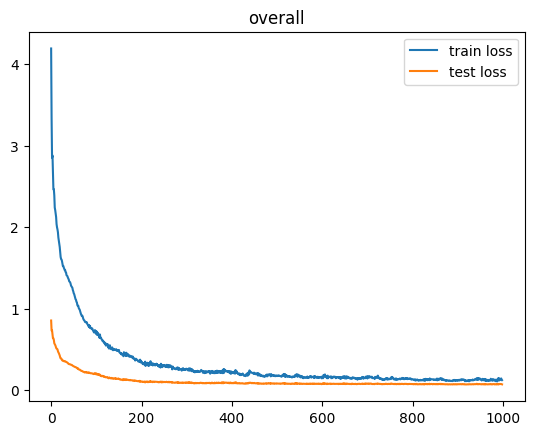

In [50]:
# total loss
import matplotlib.pyplot as plt

plt.plot(losses)
plt.plot(test_losses)
plt.legend(['train loss', 'test loss'])
plt.title('overall')

Text(0.5, 1.0, 'single')

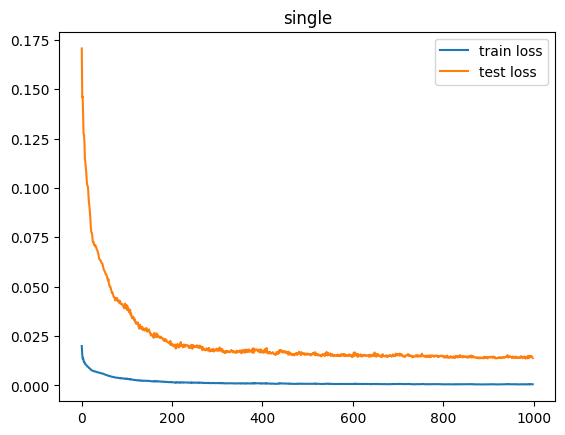

In [51]:
single_losses = np.array(losses) / 210
single_test_losses = np.array(test_losses) / (test.shape[0] // 10)

plt.plot(single_losses)
plt.plot(single_test_losses)
plt.legend(['train loss', 'test loss'])
plt.title('single')

## Make some plots

In [52]:
for i in range(1, 1):
    print(i)

In [53]:
t = torch.Tensor(col.T)
t

tensor([[0.0000e+00, 9.4000e+00, 2.4140e+05, 0.0000e+00, 0.0000e+00, 2.1345e-01,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         2.0678e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.3591e+01, 0.0000e+00,
         0.0000e+00, 2.1177e+01],
        [0.0000e+00, 8.4000e+00, 2.1230e+05, 0.0000e+00, 0.0000e+00, 1.8767e-01,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 5.7662e+01, 1.4214e+01, 2.8124e+01,
         2.0678e+00, 4.2932e-04, 0.0000e+00, 0.0000e+00, 1.3591e+01, 0.0000e+00,
         0.0000e+00, 2.1266e+01]])

In [54]:
t.reshape((1, 2, 20))

tensor([[[0.0000e+00, 9.4000e+00, 2.4140e+05, 0.0000e+00, 0.0000e+00,
          2.1345e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 2.0678e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 1.3591e+01, 0.0000e+00, 0.0000e+00, 2.1177e+01],
         [0.0000e+00, 8.4000e+00, 2.1230e+05, 0.0000e+00, 0.0000e+00,
          1.8767e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 5.7662e+01,
          1.4214e+01, 2.8124e+01, 2.0678e+00, 4.2932e-04, 0.0000e+00,
          0.0000e+00, 1.3591e+01, 0.0000e+00, 0.0000e+00, 2.1266e+01]]])